# The Battle of Neighborhoods Final Project

## 1. Introduction/Business Problem

You have just learned some new skills and now you have been headhunted by two great companies. One is located in New York and the other is in Toronto. You know you will accept one of these amazing roles, but you want to know more about the areas in these cities in order to make an informed decision. You will want to find neighbourhoods that offer great amenities and other  venues like school, gym, swimming pool, Amusement park, restaurants, coffee-shops, etc. So lets look at borough-neighbourhoods that are very similar to your current location. 

## 2. Load the Libraries and gather the Data

In [7]:
import json, requests
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from geopy.geocoders import Nominatim
import folium 
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
!pip install matplotlib-venn
from matplotlib_venn import venn2
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans

  Created wheel for matplotlib-venn: filename=matplotlib_venn-0.11.5-py3-none-any.whl size=32399 sha256=1f765fdfb8ac75bbfcd625278371c852fd164c6cd179ab3ac283c9b79ef6d794
  Stored in directory: c:\users\mlh1c17\appdata\local\pip\cache\wheels\00\81\bf\d39e58069f878a6cd3ac64624d8c774aaa56b46432a956157a
Successfully built matplotlib-venn


## 2.1 Reading the Data

### 2.1.1 New York Data

In [10]:
with open('newyork_data.json') as f:
    ny_json = json.load(f)

# relevant information is in 'features' key
ny_json = ny_json['features']
ny_json[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [11]:
#let's make an empty dataframe and put the useful information of json data into dataframe
cols = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude']
ny_df = pd.DataFrame(columns = cols)
for data in ny_json:
    borough = data['properties']['borough']
    neigh   = data['properties']['name']
    lat_lon = data['geometry']['coordinates'] # now it'll return list
    lon, lat = lat_lon[0], lat_lon[1]
    
    ny_df = ny_df.append({'Borough': borough,'Neighbourhood': neigh, 'Latitude': lat,
                          'Longitude': lon}, ignore_index=True)
    
ny_df.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### 2.1.2 Toronto Data

In [13]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source = requests.get(url).text
soup = BeautifulSoup(source)

table_data = soup.find('div', class_='mw-parser-output')
table = table_data.table.tbody

columns = ['Postal Code', 'Borough', 'Neighbourhood']
data = dict({key:[]*len(columns) for key in columns})

for row in table.find_all('tr'):
    for i,column in zip(row.find_all('td'),columns):
        i = i.text
        i = i.replace('\n', '')
        data[column].append(i)
        
toronto_df = pd.DataFrame.from_dict(data=data)[columns]
print("Before dropping the 'Not assigned' rows, shape is: ",toronto_df.shape)

toronto_df = toronto_df[toronto_df['Borough'] != 'Not assigned'].reset_index(drop = True)
print('After dropping rows where borough is "Not assigned", Shape is: ',toronto_df.shape)
print('Number of rows where Neighbourhood is "Not assigned" but borough has value: ', 
      toronto_df[toronto_df['Neighbourhood'] == 'Not assigned'].shape[0])

# making corresponding Borough as Neighbourhood: where Neighbourhood is 'Not assigend'
p, b, n = [], [], []
for postcode, borough, neigh in zip(toronto_df['Postal Code'], toronto_df['Borough'], toronto_df['Neighbourhood']):
    p.append(postcode)
    b.append(borough)
    if neigh == 'Not assigned':
        n.append(borough)
    else:
        n.append(neigh)

toronto_df = pd.DataFrame({'Postal Code': p, 'Borough': b, 'Neighbourhood':n})[columns]

#merging the rows, where Postal Code and Borough is same and Neighbourhoods will be seperated by ','
# :https://stackoverflow.com/a/27298308
toronto_df = toronto_df.groupby(['Postal Code', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()
print('Before Adding the latitude and longitue, shape is: ',toronto_df.shape)

latlon = pd.read_csv('Geospatial_Coordinates.csv')
#mergign the latitude and longitude
print("\nColumns of latlon are: {},\nSo merging on '{}'".format(latlon.columns, latlon.columns[0]))
toronto_df = pd.merge(toronto_df, latlon, how= 'inner', on = 'Postal Code')
print('Final Shape of data is: ', toronto_df.shape)

Before dropping the 'Not assigned' rows, shape is:  (180, 3)
After dropping rows where borough is "Not assigned", Shape is:  (103, 3)
Number of rows where Neighbourhood is "Not assigned" but borough has value:  0
Before Adding the latitude and longitue, shape is:  (103, 3)

Columns of latlon are: Index(['Postal Code', 'Latitude', 'Longitude'], dtype='object'),
So merging on 'Postal Code'
Final Shape of data is:  (103, 5)


In [14]:
toronto_df.head(10)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


## 2.2 Getting Venues USing Foursquare API

In [20]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET: ' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET: 


In [21]:
def get_near_by_venues(names, latitudes, longitudes, radius= 1000):    
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)    

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, 
                             v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],
                             v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue in venues_list for item in venue])
    nearby_venues.columns = ['Neighbourhood','Neighbourhood Latitude', 'Neighbourhood Longitude', 
                             'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return nearby_venues

In [22]:
def explore_borough(df, borough):
    new_df = df[df['Borough'] == borough].reset_index(drop = True)
    venues =  get_near_by_venues(names = new_df['Neighbourhood'],latitudes = new_df['Latitude'],
                                 longitudes = new_df['Longitude'])

    onehot_df = pd.get_dummies(venues[['Venue Category']], prefix= "", prefix_sep= "")

    # # add neighborhood column back to dataframe
    onehot_df['Neighbourhood'] = venues['Neighbourhood']
    # move neighborhood column to the first column
    fixed_columns = [onehot_df.columns[-1]] + list(onehot_df.columns[:-1])
    onehot_df = onehot_df[fixed_columns]
    onehot_df_grouped = onehot_df.groupby('Neighbourhood').mean().reset_index()
    
    onehot_coded_df = pd.merge(new_df, onehot_df_grouped, on = 'Neighbourhood', how = 'left')
    
    return onehot_coded_df

In [23]:
def return_venues_for_boroughs(df):
    col = list(df.columns)
    all_venues = pd.DataFrame()
    for i in df['Borough'].unique():
        new_df = df[df['Borough'] == i]
        print('For borough: ',i)
        a = explore_borough(new_df, i)
        all_venues = pd.concat([a, all_venues], axis = 0, ignore_index = True, sort = True)
    cols = col + [j for j in all_venues.columns if j not in col]
    all_venues = all_venues[cols]
    return all_venues

### 2.2.1 New York City data

In [30]:
try:
    df1 = pd.read_csv('New_York.csv')
except:
    df1 = return_venues_for_boroughs(ny_df)
    df1.fillna(0,  inplace = True)
    df1.to_csv('New_York.csv',  index_label = False)
print('Shape data is: ', df1.shape)
df1.head()

For borough:  Bronx
For borough:  Manhattan
For borough:  Brooklyn
For borough:  Queens
For borough:  Staten Island
Shape data is:  (306, 476)


,Borough,Neighbourhood,Latitude,Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Gym,College Theater,College Track,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cruise,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern Greek Restaurant,Molecular Gastronomy Restaurant,Monument / 

### 2.2.2 Toronto City

In [26]:
try:
    df2 = pd.read_csv('Toronto_venue.csv')
except:
    df2 = return_venues_for_boroughs(toronto_df)
    df2.fillna(0, inplace = True)
    df2.to_csv('Toronto_venue.csv',  index_label = False)
print('Shape data is: ', df2.shape)
df2.head()

For borough:  Scarborough
For borough:  North York
For borough:  East York
For borough:  East Toronto
For borough:  Central Toronto
For borough:  Downtown Toronto
For borough:  York
For borough:  West Toronto
For borough:  Mississauga
For borough:  Etobicoke
Shape data is:  (103, 336)


,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Lab,College Quad,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Light Rail Station,Lighting Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Sh

# 3. Exploratory Data Analysis (EDA)

The data set have different numbers of column, but many of these contain the same data. We will identify how many of them are shared

Common Venue categories

Let's find out how many venue categories are common in both cities data.
We'll deal with only common vanue categories data amd rest other venue categories will be dropped.

In [31]:
print('Leaving {} columns of New York city data\nLeaving {} columns of Toronto city data'
      .format(list(df1.columns[0:4]), list(df2.columns[0:5])))
common = 0
diff_in_NY = 0

for i in df1.columns[4:]:
    if i in df2.columns[5:]:
        common += 1
    else:
        diff_in_NY += 1

print('\nNumber of common venue categories in both data are       :{}\n\
Number of different venue categories in New York city are: {}\n\
Number of different venue catehories in Toronto city are : {}'.format(common, diff_in_NY,
                                                                     len(df2.columns[5:])-common))

Leaving ['Borough', 'Neighbourhood', 'Latitude', 'Longitude'] columns of New York city data
Leaving ['Postal Code', 'Borough', 'Neighbourhood', 'Latitude', 'Longitude'] columns of Toronto city data

Number of common venue categories in both data are       :292
Number of different venue categories in New York city are: 180
Number of different venue catehories in Toronto city are : 39


### Use a Venn diagram to visualise the data

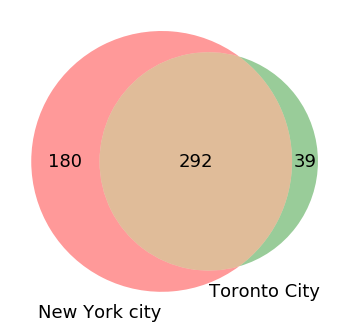

In [32]:
cl1 = set(df1.columns[4:])
cl2 = set(df2.columns[5:])
plt.figure(figsize = (6,6))
out = venn2([set(cl1), set(cl2)], set_labels = ['New York city', 'Toronto City'])
# chnage the text size of matplotlib venn:https://stackoverflow.com/a/29426251
for text in out.set_labels:
    text.set_fontsize(18)
for text in out.subset_labels:
    text.set_fontsize(18)
plt.show()

### Focus on common venue categories of both cities and drop the remaining categories from the analysis

In [33]:
comm_col = []
for i in df1.columns[4:]:
    if i in df2.columns[5:]:
        comm_col.append(i)

col1 = list(df1.columns[0:4]) + comm_col
col2 = list(df2.columns[0:5]) + comm_col
print('Before removing non-common shape of New York: {}, and shape of Toronto is: {}'
      .format(df1.shape, df2.shape))
df1 = df1.loc[:, col1]
df2 = df2.loc[:, col2]
print('After removing non-common shape of New York: {}, and shape of Toronto is: {}'
      .format(df1.shape, df2.shape))

Before removing non-common shape of New York: (306, 476), and shape of Toronto is: (103, 336)
After removing non-common shape of New York: (306, 296), and shape of Toronto is: (103, 297)


# 5. Find the most similar Locations in the other City

1. To find the most similar city, cosine similarity will be used.
2. This kind of recommendation comes under item-item based recommender system.

We will focus on the top 7 boroughs based on similarity

In [34]:
def return_ordered_num(n_most_similar):
    a = ['st', 'nd', 'rd']
    c = []
    for i in range(1,20+1):
        if i == 1:
            c.append(str(i)+str(a[i-1]))
        elif i == 2:
            c.append(str(i)+str(a[i-1]))
        elif i == 3:
            c.append(str(i)+str(a[i-1]))
        else:
            c.append(str(i)+'th')
    return c

In [35]:
index = df1.loc[(df1['Borough'] == 'Bronx') 
                & (df1['Neighbourhood'] == 'Riverdale')].index.values.astype(int)[0]
lat = df1.loc[index]['Latitude']
lon = df1.loc[index]['Longitude']
print('Index    :{}\nLatitude : {}\nLongitude: {}'.format(index, lat, lon))

Index    :258
Latitude : 40.890834493891305
Longitude: -73.9125854610857


In [36]:
ny_data = df1.loc[:,comm_col] # selecting only common venues
toronto_data = df2.loc[:,comm_col] # selecting only common venues

# converting into numpy ndarray
X1 = ny_data.values
X2 = toronto_data.values
print('Shape of X1: {}\nShape of X2: {}'.format(X1.shape, X2.shape))

Shape of X1: (306, 292)
Shape of X2: (103, 292)


#### Find the similarity between boroughs using cosine similarity

In [37]:
a = np.matmul(X1[index], X2.T)
#return the index in sorted order (descending)of values, 
#first element correspond to the index of maximum value in a
aa = np.argsort(-a)[0:7] 
my_borough = df2.iloc[aa, :]
print(my_borough.shape)
my_borough.head()

(7, 297)


,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Steakhouse,Storage Facility,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turki

#### Now we we need to visulaise this using folium

In [38]:
c = return_ordered_num(7)

current_location_popup = 'Bronx, Riverdale, New York'
label1 = folium.Popup(current_location_popup, parse_html=True)

my_map = folium.Map(location = [lat, lon], zoom_start = 6)
folium.CircleMarker([lat, lon], color = 'red', radius = 5,
                    popup = label1, fill_color = '#3186cc', fill_opacity = 1,
                    fill = True, tooltip = 'current location').add_to(my_map)

# add markers to map
for lat, lng, label, priority in zip(my_borough['Latitude'], my_borough['Longitude'], 
                                     my_borough['Neighbourhood'], c):
    label = folium.Popup(label, parse_html=True)
    folium.Marker([lat, lng], radius = 5, popup=label, color='blue', 
                  tooltip = priority, parse_html=False).add_to(my_map)
    
my_map

# 6. Create a function to identify the similar boroughs from the last step
#### We will run it both ways to identify which neighbourhoods are the most similar across the cities

In [39]:
def most_similar_borough(current_city, current_borough, current_neigh, n_most_similar):
    ny_data = df1.iloc[:,4:]
    toronto_data = df2.iloc[:,5:]
    if current_city.lower() == 'New York'.lower():
        X1 = ny_data.values
        X2 = toronto_data.values
        index = df1.loc[(df1['Borough'] == current_borough) 
                        & (df1['Neighbourhood'] == current_neigh)].index.values.astype(int)[0]
        lat = df1.loc[index]['Latitude']
        lon = df1.loc[index]['Longitude']
    else:
        X1 = toronto_data.values
        X2 = ny_data.values
        index = df2.loc[(df2['Borough'] == current_borough) 
                & (df2['Neighbourhood'] == current_neigh)].index.values.astype(int)[0]
        lat = df2.loc[index]['Latitude']
        lon = df2.loc[index]['Longitude']
    
    a = np.matmul(X1[index], X2.T)
    aa = np.argsort(-a)[0:n_most_similar]
    
    if current_city.lower() == 'New York'.lower():
        my_borough = df2.iloc[aa, :]
    else:
        my_borough = df1.iloc[aa, :]
   
    # for tooltip of map
    c = return_ordered_num(n_most_similar)
    
    current_location_popup = '{}, {}, {}'.format(current_neigh, current_borough, current_city)
    label1 = folium.Popup(current_location_popup, parse_html=True)
    
    my_map = folium.Map(location = [lat, lon], zoom_start = 6)
    folium.CircleMarker([lat, lon], color = 'red', radius = 5,
                        popup = label1, fill_color = '#3186cc', fill_opacity = 1,
                        fill = True, tooltip = 'current location').add_to(my_map)

    # add markers to map
    for lat, lng, label, priority in zip(my_borough['Latitude'], my_borough['Longitude'], 
                                         my_borough['Neighbourhood'], c):
        label = folium.Popup(label, parse_html=True)
        folium.Marker([lat, lng], radius = 5, popup=label, color='blue', 
                      tooltip = priority, parse_html=False).add_to(my_map)  

    return my_map

### From New York to Toronto

In [40]:
most_similar_borough(current_city = 'New York', current_borough = 'Bronx',
                     current_neigh = 'Riverdale', n_most_similar = 7)

### From Toronto to New York

In [41]:
most_similar_borough(current_city = 'Toronto', current_borough = 'Etobicoke',
                     current_neigh = 'Alderwood, Long Branch', n_most_similar = 10)